# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

## Add Attributes name

The raw data doesn't name any Attribute.

Attributes' mean see : https://archive.ics.uci.edu/ml/datasets/Dota2+Games+Results

In [2]:
Attributes = ['Team-won', 'Cluster-ID', 'Game-mode', 'Game-type']
for i in range(0, 113):
    Attributes.append('hero' + str(i))

In [3]:
train = pd.read_csv('input/dota2Train.csv', names=Attributes)
test = pd.read_csv('input/dota2Test.csv', names=Attributes)

In [4]:
train.head()

,Team-won,Cluster-ID,Game-mode,Game-type,hero0,hero1,hero2,hero3,hero4,hero5,...,hero103,hero104,hero105,hero106,hero107,hero108,hero109,hero110,hero111,hero112
0,-1,223,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,171,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0


Cluster-ID seems don't contribute to my prediction,

I **finally** decided to remove the feature.

The code I writed here just because of clean code.

In [5]:
train = train.drop('Cluster-ID', axis = 1)
test = test.drop('Cluster-ID', axis = 1)

## Target

I want to predict which team would win the game in what condition.

First I will show some information in the data by visualization or just count value.

Winrate seems Evenly distributed.

In [6]:
print(train['Team-won'].value_counts()/train.shape[0])
print(test['Team-won'].value_counts()/test.shape[0])

 1    0.526519
-1    0.473481
Name: Team-won, dtype: float64
 1    0.534486
-1    0.465514
Name: Team-won, dtype: float64


Below is correlation between features,

And I add `hero1` just for compare.

The result show all the feature have low correlation to win, so I must find out other way to train my model.

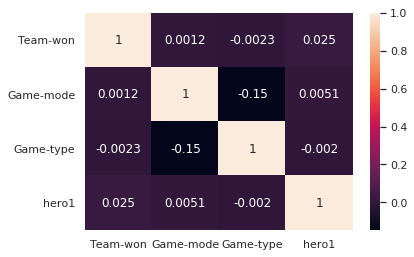

In [7]:
pd_feature = train[['Team-won', 'Game-mode', 'Game-type', 'hero1']]
pd_feature.corr()
import seaborn as sns
sns.set()
ax = sns.heatmap(pd_feature.corr(), annot=True)

In [8]:
count_nu = train.isnull().sum()
count_nu[count_nu > 0].sort_values(ascending=False)

Series([], dtype: int64)

## Feature combination

Beacause the correlation between heros and result is too small, 

so I would like to combinate feature of Hertos to a new feature or two feature.

My thoughts is to compute the win rate of heros, then decide the weight of hero base of his win rate.

After the weight is determined, each game's hero multiple his weight and sum them up.

Then both two side get their heros' strength, that is the new feature.

Take game0 as example, positive side took hero 9, 13 24 27 32,

so the `pos_strength[0]` = hero_winrate[9] + hero_winrate[13] + hero_winrate[24] + hero_winrate[27] + hero_winrate[32]

negtive side took hero 17, 21, 37, 73, 87

so the `neg_strength[0]` = hero_winrate[17] + hero_winrate[21] + hero_winrate[37] + hero_winrate[73] + hero_winrate[87]

In [9]:
hero_winrate = []
index = []
for i in range(0, 113):
    win = 0
    lose = 0
    hero = train.groupby(['hero' + str(i)])
    if 1 in list(hero.groups):
        ind_pos1 = hero.groups[1]
    else:
        ind_pos1 = [-1]
        
    if -1 in list(hero.groups):
        ind_neg1 = hero.groups[-1]
    else:
        ind_neg1 = [-1]
        
    if ind_pos1[0] != -1:
        win += (train['Team-won'][ind_pos1] == 1).value_counts().loc[True]
        lose += (train['Team-won'][ind_pos1] == 1).value_counts().loc[False]
    if ind_neg1[0] != -1:
        win += (train['Team-won'][ind_neg1] == -1).value_counts().loc[True]
        lose += (train['Team-won'][ind_neg1] == -1).value_counts().loc[False]
    if win+lose != 0:
        hero_winrate.append(win/(win+lose))
    else:
        hero_winrate.append(0)
    index.append(i)
hero_winrate[:10]

[0.46697388632872505,
 0.5270430319778918,
 0.4500792393026941,
 0.5075200820372586,
 0.5476616915422886,
 0.5347465437788018,
 0.5015963107484924,
 0.5043940498135208,
 0.5532014478282576,
 0.5014785357397777]

In [10]:
hero_winrate = pd.Series(hero_winrate)
print(hero_winrate.sort_values(ascending=False).head(5))
print(hero_winrate.sort_values(ascending=False).tail(5))

56     0.608534
102    0.585669
35     0.564451
66     0.553874
41     0.553476
dtype: float64
79     0.386032
60     0.376020
90     0.355528
23     0.000000
107    0.000000
dtype: float64


In [11]:
strength_compute = train.drop(['Team-won', 'Game-mode', 'Game-type'], axis = 1)
pos_strength = []
neg_strength = []
for i in range (train.shape[0]):
    tmp_pos = 0
    tmp_neg = 0
    pos = strength_compute.loc[i] == 1
    neg = strength_compute.loc[i] == -1
    for j in range (0,5):
        tmp_pos += hero_winrate[int(pos[pos].index[j][4:])]
        tmp_neg += hero_winrate[int(neg[neg].index[j][4:])]
    pos_strength.append(tmp_pos)
    neg_strength.append(tmp_neg)

In [12]:
imp_train = train[['Team-won', 'Game-mode', 'Game-type']]
imp_train.insert(3, 'pos_strength', pos_strength)
imp_train.insert(4, 'neg_strength', neg_strength)
imp_train.head()

,Team-won,Game-mode,Game-type,pos_strength,neg_strength
0,-1,2,2,2.514413,2.536970
1,1,2,2,2.555158,2.457343
2,1,2,2,2.503338,2.445977
3,1,2,2,2.466827,2.521910
4,-1,2,3,2.605088,2.531599


In [13]:
strength_compute = test.drop(['Team-won', 'Game-mode', 'Game-type'], axis = 1)
pos_strength_test = []
neg_strength_test = []
for i in range (test.shape[0]):
    tmp_pos = 0
    tmp_neg = 0
    pos = strength_compute.loc[i] == 1
    neg = strength_compute.loc[i] == -1
    for j in range (0,5):
        tmp_pos += hero_winrate[int(pos[pos].index[j][4:])]
        tmp_neg += hero_winrate[int(neg[neg].index[j][4:])]
    pos_strength_test.append(tmp_pos)
    neg_strength_test.append(tmp_neg)

In [14]:
imp_test = test[['Team-won', 'Game-mode', 'Game-type']]
imp_test.insert(3, 'pos_strength', pos_strength_test)
imp_test.insert(4, 'neg_strength', neg_strength_test)
imp_test.head()

,Team-won,Game-mode,Game-type,pos_strength,neg_strength
0,-1,8,2,2.494588,2.547145
1,1,8,2,2.496447,2.458664
2,-1,2,2,2.569870,2.453287
3,1,2,2,2.472009,2.326554
4,1,2,3,2.356313,2.508575


In [15]:
train_x = train.drop('Team-won', axis = 1)
train_y = train['Team-won']
test_x = test.drop('Team-won', axis = 1)
test_y = test['Team-won']
imp_train_x = imp_train.drop('Team-won', axis = 1)
imp_train_y = imp_train['Team-won']
imp_test_x = imp_test.drop('Team-won', axis = 1)
imp_test_y = imp_test['Team-won']

In [16]:
imp_test.to_csv("imp_test.csv", index = False)
imp_train.to_csv("imp_train.csv", index = False)

## Training

In the process I tried, lots of model make my jupyter no response(KNeighborsClassifier, SVC...)

On my opinion, it maybe the memory is full cause data set is gigantic.

maybe smaller data set would have better result.

so below models is almost the most models I can use.

The combination of feature just make 0.06~0.07 improve of correcness.

However, it is weird that in MLPClassifier, improvement data is lower than origin.

If I have time, I would try other parameter of these model.

Unfortunately, I am very sleepy right now, and sun is raised.

I can't do anythinf at all.

In [17]:
dtree = DecisionTreeClassifier(max_depth = 5)
dtree.fit(train_x, train_y)
dtree.score(test_x, test_y)

0.5434233534097532

In [18]:
dtree = DecisionTreeClassifier(max_depth = 5)
dtree.fit(imp_train_x, imp_train_y)
dtree.score(imp_test_x, imp_test_y)

0.5941325043714786

In [19]:
model = RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1)
model.fit(train_x, train_y)
model.score(test_x, test_y)

0.5399261705848066

In [20]:
model = RandomForestClassifier(max_depth=5, n_estimators=12, max_features='auto')
model.fit(imp_train_x, imp_train_y)
model.score(imp_test_x, imp_test_y)

0.5944239362735574

In [21]:
model = MLPClassifier(alpha=0.0001, max_iter=1000)
model.fit(train_x, train_y)
model.score(test_x, test_y)

0.5944239362735574

In [22]:
model = MLPClassifier(alpha=0.0001, max_iter=1000)
model.fit(imp_train_x, imp_train_y)
model.score(imp_test_x, imp_test_y)

0.5854866912764717